In [2]:
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy import misc
import numpy as np
import os
import random
import theano
import theano.tensor as T
from theano.tensor.nnet import conv, sigmoid
from theano import function, config, shared, sandbox

imdir = "images/raw"
handles = os.listdir(imdir)
print "Selecting from %d images" % len(handles)
random.shuffle(handles)
fname = os.path.join(imdir, handles[0])

%matplotlib inline
%time im = [misc.imread(fname) for _ in xrange(10)][-1]
%time imf1 = [misc.fromimage(misc.toimage(im), flatten=True) for _ in xrange(10)][-1]
%time imf2 = [misc.imread(fname, flatten=True) for _ in xrange(10)][-1]

Selecting from 126905 images
CPU times: user 99 ms, sys: 5.18 ms, total: 104 ms
Wall time: 106 ms
CPU times: user 20.9 ms, sys: 7.2 ms, total: 28.1 ms
Wall time: 28.3 ms
CPU times: user 103 ms, sys: 2.95 ms, total: 106 ms
Wall time: 108 ms


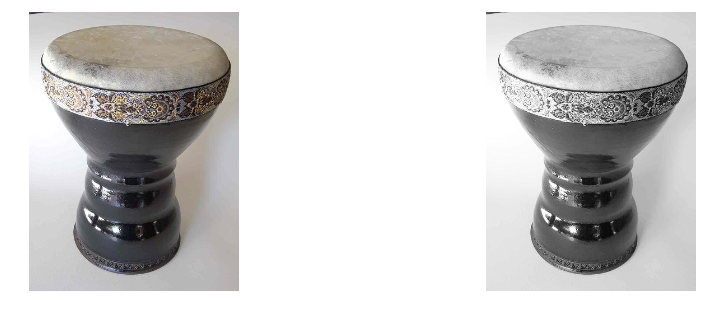

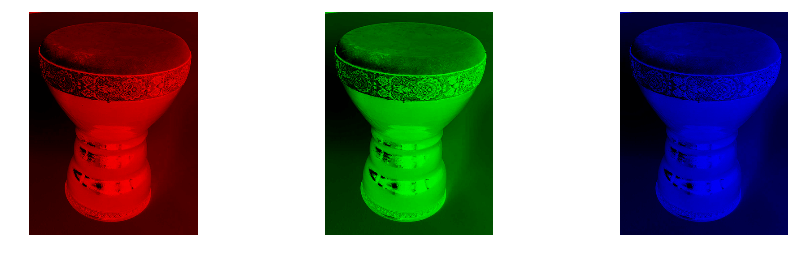

In [3]:
def gshow(i):
    plt.imshow(i, cmap=cm.Greys_r)

fig = plt.figure(figsize=(15, 5))
fig.add_subplot(121)
plt.axis("off")
plt.imshow(im)
fig.add_subplot(122)
plt.axis("off")
gshow(imf1)
plt.show()

fig = plt.figure(figsize=(15, 4))
fig.add_subplot(131)
plt.axis("off")
plt.imshow(im * [[[1, 0, 0]]])
fig.add_subplot(132)
plt.axis("off")
plt.imshow(im * [[[0, 1, 0]]])
fig.add_subplot(133)
plt.axis("off")
plt.imshow(im * [[[0, 0, 1]]])
plt.show()

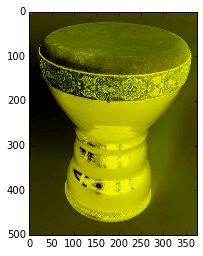

In [4]:
red = T.ftensor3("red")
green = T.ftensor3("green")
rg = red + green
f = function([red, green], rg, allow_input_downcast=True)
result = f(im * [[[1, 0, 0]]], im * [[[0, 1, 0]]])
plt.imshow(result)

In [10]:
r = im * [[[1, 0, 0]]]
g = im * [[[0, 1, 0]]]
print "Using Theano"
%time [f(r, g) for _ in xrange(30)][0]
print "Using NumPy"
%time [r + g for _ in xrange(30)][0]
None

Using Theano
CPU times: user 92.9 ms, sys: 50.6 ms, total: 144 ms
Wall time: 147 ms
Using NumPy
CPU times: user 51.9 ms, sys: 49.7 ms, total: 102 ms
Wall time: 104 ms


In [11]:
def DownsampledPatch(image, max_x, max_y):
    y, x = image.shape[:2]
    y_ratio = max_y / float(y)
    x_ratio = max_x / float(x)
    scale = max(x_ratio, y_ratio)
    return misc.imresize(image, scale)[:max_y,:max_x]



In [13]:
rng = np.random.RandomState(23451)

# instantiate 4D tensor for input
inp = T.tensor4(name='inp')

# initialize shared variable for weights.
w_shp = (1, 1, 9, 9)
w_bound = np.sqrt(np.prod(w_shp))
W = theano.shared(np.asarray(
            rng.uniform(
                low=-1.0 / w_bound,
                high=1.0 / w_bound,
                size=w_shp),
            dtype=inp.dtype), name ='W')
# bias
b_shp = (1,)
b = theano.shared(np.asarray(
            rng.uniform(low=-.5, high=.5, size=b_shp),
            dtype=inp.dtype), name ='b')

# build symbolic expression that computes the convolution of input with filters in w
conv_out = conv.conv2d(inp, W)

# bias and activation
output = sigmoid(conv_out + b.dimshuffle('x', 0, 'x', 'x'))
f = theano.function([inp], output)

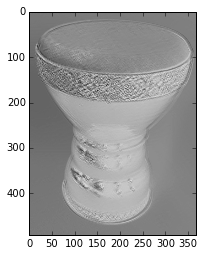

In [14]:
x, y = imf1.shape
imf1_ = (imf1 / 256).reshape(1, 1, x, y)
gshow(f(imf1_)[0, 0, :, :])

In [15]:
import nets
reload(nets)
cm = nets.ColorizerNet(
    rng=rng,
    image_shape=(100, 100),
    batch_size=1,
    nkerns=(5, 10),
    filter_span=5,
    poolsize=2,
    nonlin=T.tanh)
    

Building the model...
Creating a max pooling layer...
Creating a max pooling layer...
Creating a hidden layer...


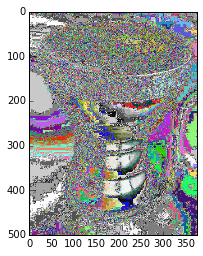

In [16]:
a = T.tensor3('a')
b = T.tanh(a)
g = theano.function([a], b)

x, y = imf2.shape
im_ = im / 256.0
plt.imshow(g(im_) * 256)

In [17]:
import lasagne
from lasagne import layers
from lasagne import nonlinearities
from lasagne import updates
from nolearn.lasagne import base

image_shape = [100, 100]
pool_size = 2

net_layers = (
    # -> (1, 1, 100, 100)
    (layers.InputLayer, {
        'shape': [1, 1, 100, 100],
        'name': 'input'}),

    # -> (1, 5, 100, 100)
    (layers.Conv2DLayer, {
        'incoming': 'input',
        'num_filters': 5,
        'filter_size': (5, 5),
        'nonlinearity': nonlinearities.rectify,
        'border_mode': 'same',
        'name': 'conv1'}),

    # -> (1, 10, 100, 100)
    (layers.Conv2DLayer, {
        'incoming': 'conv1',
        'num_filters': 10,
        'filter_size': (7, 7),
        'nonlinearity': nonlinearities.rectify,
        'border_mode': 'same',
        'name': 'conv2'}),

    # -> (1, 50, 100, 100)
    (layers.Conv2DLayer, {
        'incoming': 'input',
        'num_filters': 50,
        'filter_size': (1, 1),
        'nonlinearity': nonlinearities.rectify,
        'name': 'proj1'}),

    # -> (1, 5, 100, 100)
    (layers.Conv2DLayer, {
        'incoming': 'proj1',
        'num_filters': 5,
        'filter_size': (1, 1),
        'nonlinearity': nonlinearities.rectify,
        'name': 'proj2'}),

    # -> (1, 10, 100, 100)
    (layers.ConcatLayer, {
        'incomings': ('conv2', 'proj2'),
        'axis': 1,
        'name': 'concat'}),

    # -> (1, 3, 100, 100)
    (layers.Conv2DLayer, {
        'incoming': 'concat',
        'num_filters': 3,
        'filter_size': (1, 1),
        'nonlinearity': nonlinearities.rectify,
        'name': 'output'}))

In [18]:
reload(base)
net1 = base.NeuralNet(
    layers=net_layers,
    update=updates.adagrad,
    update_learning_rate=0.04,
    verbose=1,
    max_epochs=2,
    regression=True)

In [19]:
import image
reload(image)

<module 'image' from 'image.pyc'>

In [20]:
examples = (image.LoadColorAndGreyscaleImages(os.path.join(imdir, handles[x])) for x in xrange(100))
examples = [(image.DownsampledPatch(c, 100, 100) / 255.0, image.DownsampledPatch(g, 100, 100) / 255.0)
            for c, g in examples
            if c is not None and g is not None]
colors = np.array([c for c, _ in examples])
colors = colors.astype(np.float32).reshape(len(colors), 3, 100, 100)
greys = np.array([g for _, g in examples])
greys.resize(greys.shape + (1,))
greys = greys.astype(np.float32).reshape(len(colors), 1, 100, 100)

cannot identify image file 'images/raw/n04167346_7100.jpg'
Skipping greyscale image.
cannot identify image file 'images/raw/n03724538_4800.jpg'
cannot identify image file 'images/raw/n07717556_1153.jpg'
cannot identify image file 'images/raw/n03257210_18675.jpg'
Skipping greyscale image.
cannot identify image file 'images/raw/n12020184_6908.jpg'
Skipping greyscale image.
cannot identify image file 'images/raw/n11646167_1109.jpg'
Skipping greyscale image.
cannot identify image file 'images/raw/n03125057_10628.jpg'
Skipping greyscale image.
cannot identify image file 'images/raw/n03437941_3096.jpg'
Skipping greyscale image.
Skipping greyscale image.
Skipping greyscale image.
Skipping greyscale image.


In [21]:
net1.fit(greys, colors)

# Neural Network with 2993 learnable parameters

## Layer information

|   # | name   | size       |
|----:|:-------|:-----------|
|   0 | input  | 1x100x100  |
|   1 | conv1  | 5x100x100  |
|   2 | conv2  | 10x100x100 |
|   3 | proj1  | 50x100x100 |
|   4 | proj2  | 5x100x100  |
|   5 | concat | 15x100x100 |
|   6 | output | 3x100x100  |



/Users/Jeff/anaconda/lib/python2.7/site-packages/Lasagne-0.1.dev0-py2.7.egg/lasagne/init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "
/Users/Jeff/anaconda/lib/python2.7/site-packages/Lasagne-0.1.dev0-py2.7.egg/lasagne/layers/helper.py:69: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "


TypeError: ('Bad input argument to theano function with name "/Users/Jeff/anaconda/lib/python2.7/site-packages/nolearn-0.6a0.dev0-py2.7.egg/nolearn/lasagne/base.py:272"  at index 1(0-based)', 'Wrong number of dimensions: expected 2, got 4 with shape (66, 3, 100, 100).')

In [37]:
net1.get_all_layers()[-1].output_shape

(1, 3, 100, 100)